# Global and Local Explanation for XGBoost model on PTB data


In [163]:
import sys
import os
data_path = ''
# Check if the environment is Google Colab
if 'google.colab' in sys.modules:
    print("Running on Google Colab")
    # Install required libraries
    !pip install tensorflow -q
    !pip install keras -q
    !pip install scikit-learn -q
    !pip install pandas -q
    !pip install numpy -q
    !pip install matplotlib -q
    !pip install umap-learn -q
    !pip install lightgbm
    !pip install xgboost

    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    # set the path where the csv file stored in your own google drive. 
    data_path = '/content/drive/MyDrive/Heartbeat_Project/'
    
else:
    print("Running on local environment")

    current_path = os.getcwd()
    print("Current working directory:", current_path)
    data_path = '../data/raw/'

Path = dict({
    'ptbdb_normal': data_path +  'ptbdb_normal.csv',
    'ptbdb_abnormal':  data_path + 'ptbdb_abnormal.csv',
})

Running on local environment
Current working directory: g:\Meine Ablage\heartbeat-analysis-ai\notebooks


In [164]:
# Verify installation and import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import umap

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.manifold import TSNE, Isomap
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedRandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [165]:
def addColumnsToDataframe(df):
    """
    As the dataset is composed with 188 columns with the 188th columns as the category values,
    so we give the last column the name 'target', others named with 'c_182'
    """
    num_columns= df.shape[1]
    feature_col_name = ['c_' + str(i) for i in range(0, num_columns - 1)]
    df_columns = feature_col_name + ['target']
    df.columns = df_columns
    return df

def convertColumnAsInt(df, column):
    """
    As the category value is in float type. We want to get the int to identify the category.
    """
    df[column] = df[column].astype(int)
    return df

def getBarChartFromCategoryValueCounts(category_value_counts):
    """
    We call the plot over the pandas series object to plot the category count values
    """
    plt.figure(figsize=(10, 6))
    bar_chart = category_value_counts.plot(kind='bar')
    plt.xlabel('Categories')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(False)
    plt.xticks(rotation=360)
    for i in bar_chart.containers:
        bar_chart.bar_label(i, label_type='edge')
    plt.show()


def showTop10DataInChart(df):
    plt.figure(figsize=(10, 6))
    xDataAxis = list(range(0, df.shape[1]))
    yDataRows = list(df.values[1: 10])
    for y in yDataRows:
        plt.plot(xDataAxis, y)
    plt.show()

In [166]:
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from xgboost import XGBModel, Booster
import os

# Load
ptbdb_train = pd.read_csv('../data/processed/ptb_train_clean_default.csv')
ptbdb_test = pd.read_csv('../data/processed/ptb_test_clean_default.csv')

# Remove Dublicates
ptbdb_train = ptbdb_train.drop_duplicates()
ptbdb_test = ptbdb_test.drop_duplicates()

# Split data into features and target
X_train = ptbdb_train.drop(columns=['target'])
y_train = ptbdb_train['target']
X_test = ptbdb_test.drop(columns=['target'])
y_test = ptbdb_test['target']

# Define the model path
current_dir = os.getcwd()
model_path = os.path.join(current_dir, '..', 'models', 'model_ptb_XGBoost.pkl')



load models

In [167]:
import pickle
import matplotlib.pyplot as plt
from xgboost import plot_importance
import sklearn

# Load the XGBoost model (wrapped inside a pipeline)
model_path = r'..\models\model_ptb_XGBoost.pkl'  
with open(model_path, 'rb') as file:
    pipeline_model = pickle.load(file)

# Check the type of the model (pipeline)
print(f"Model type: {type(pipeline_model)}")




Model type: <class 'sklearn.pipeline.Pipeline'>


Feature Importance

In [168]:
# Look at the steps of the pipeline
print("Pipeline steps:", pipeline_model.named_steps)
    
# Extract the XGBoost model from the pipeline
xgb_model = pipeline_model.named_steps['xgb']  # Adjust based on the name of the XGBoost step in the pipeline

Pipeline steps: {'xgb': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)}


<Figure size 1200x800 with 0 Axes>

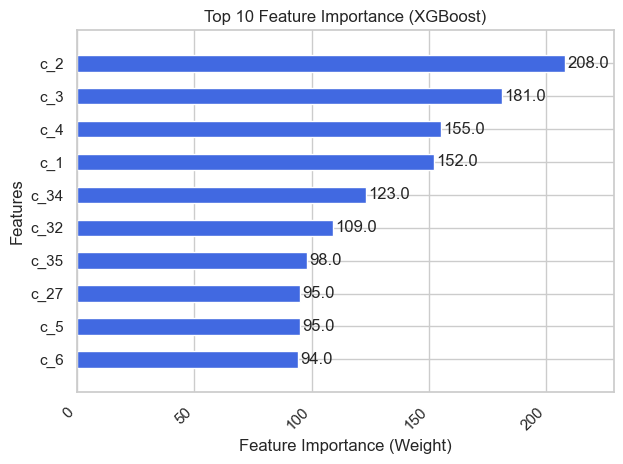

In [169]:
# visualize the feature importance
sns.set(style="whitegrid")

# Create a more attractive plot for feature importance
plt.figure(figsize=(12, 8))

# Plot feature importance with some customizations
plot_importance(
    xgb_model, 
    importance_type='weight',  # You can replace 'weight' with 'gain' or 'cover'
    max_num_features=10,  # Top 10 features
    height=0.5,  # Increase the height of the bars for better readability
    color='royalblue',  # Color for the bars
    title='Top 10 Feature Importance (XGBoost)',  # Custom title
    xlabel='Feature Importance (Weight)',  # Custom x-axis label
    ylabel='Features'  # Custom y-axis label
)

# Customize the plot further
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Make sure everything fits without overlapping

# Show the plot
plt.show()

SHAP

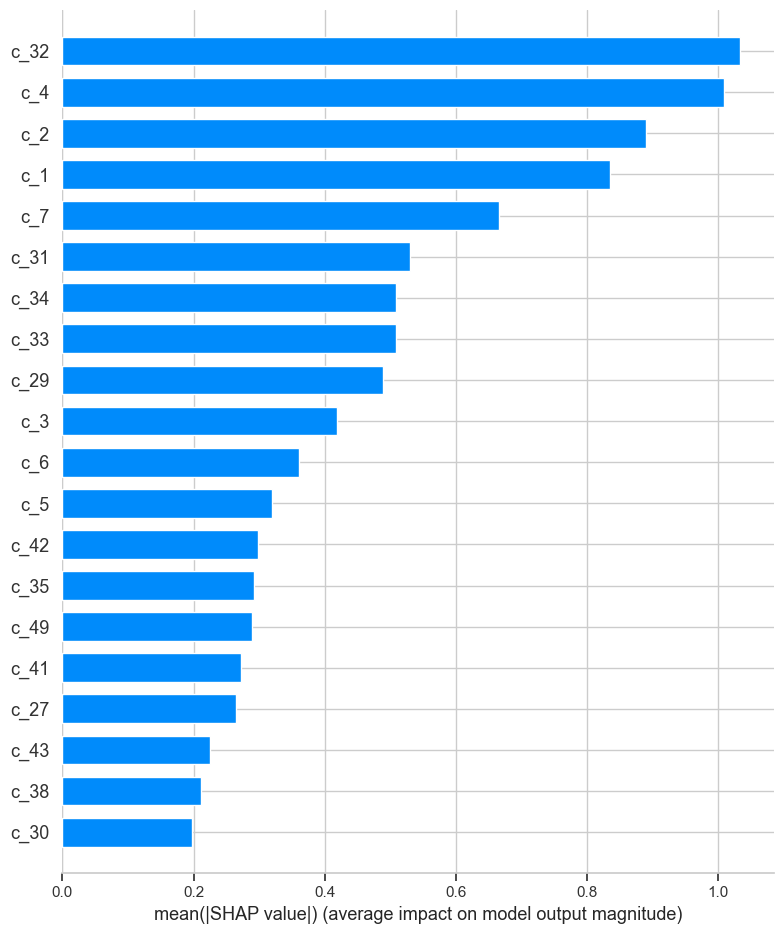

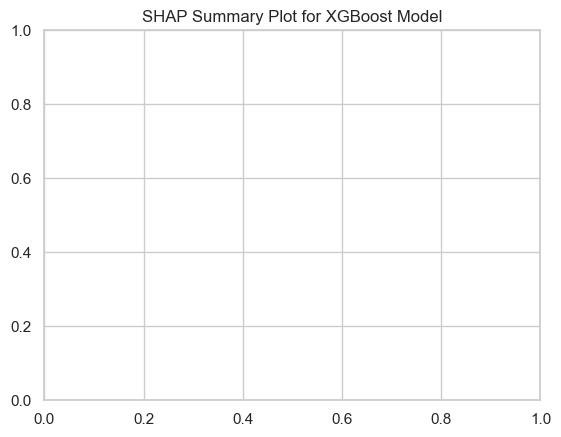

In [170]:
import shap
import matplotlib.pyplot as plt

# Create a SHAP explainer for the XGBoost model
explainer = shap.Explainer(xgb_model)

# Calculate SHAP values for the test data
shap_values = explainer.shap_values(X_test)  

# Visualize SHAP values with a summary plot for test data
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test, plot_type="bar") 
plt.title('SHAP Summary Plot for XGBoost Model')
plt.show()


LIME


In [171]:
import lime
import lime.lime_tabular

# Create a Lime Explainer object
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),  # Features from the training data
    training_labels=np.array(y_train),  # Target labels for training data
    mode="classification",  # Set to 'classification' or 'regression' based on your task
    feature_names=X_train.columns,  # Feature names
    class_names=['Class 0', 'Class 1'],  # Class names for binary classification (modify if more classes)
    discretize_continuous=True  # Discretizes continuous features for better explanation
)


In [172]:
# Select a random instance from the test set
idx = 20 # Change this index to select a different instance
instance = X_test.iloc[idx]  # The input instance

# Get the true label for the selected instance
true_label = y_test.iloc[idx]

print("True Label for selected instance:", true_label)
print("Instance features:\n", instance)


True Label for selected instance: 1
Instance features:
 c_0      0.675005
c_1     -1.285813
c_2     -1.612584
c_3     -0.202912
c_4      0.860958
           ...   
c_182   -0.048544
c_183   -0.040268
c_184   -0.027824
c_185   -0.027870
c_186    0.000000
Name: 20, Length: 187, dtype: float64
